In [1]:
import pandas as pd

train_df = pd.read_csv("train_critic.csv").dropna()  # Carregando dados de treino
test_df = pd.read_csv("test_critic.csv").dropna() # Carregando dados de teste

In [2]:
from transformers import AutoTokenizer, Trainer, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch

NUM_LABELS = 2  # Número de classes
model_name = "xlnet-base-cased"  # Escolha o modelo conforme sua necessidade
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Carregar o tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)  # Carregar o modelo de classificação

/home/felipedias/BigData/Trabalho1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-08 12:33:01.717793: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 12:33:01.725046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733671981.733943   16894 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733671981.736656   16894 cuda_bla

In [3]:
from datasets import Dataset
import tensorflow as tf
import random
import numpy as np
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


train_data_set = Dataset.from_pandas(train_df)
train_val_set = train_data_set.train_test_split (test_size = 0.2)

print(train_val_set)

x_train = train_val_set["train"]["Review"]
x_val = train_val_set["test"]["Review"]
y_train = train_val_set["train"]["Sentiment"]
y_val = train_val_set["test"]["Sentiment"]

x_test = test_df["Review"]
test_set = Dataset.from_pandas(test_df)

DatasetDict({
    train: Dataset({
        features: ['Show', 'Sentiment', 'Review', '__index_level_0__'],
        num_rows: 9464
    })
    test: Dataset({
        features: ['Show', 'Sentiment', 'Review', '__index_level_0__'],
        num_rows: 2367
    })
})


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def  plot_loss_accuracy(df):
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    sns.lineplot(data=df[['loss', 'eval_loss']])

In [23]:
from sklearn import metrics

def plot_confusion_matrix(dataset, predictions, labels=None):
    #calcula a acurácia balanceada
    labels = dataset['Sentiment']
    preds = [0 if pred['label'] == 'LABEL_0' else 1 for pred in predictions]
    
    
    print('balanced Accuracy:', balanced_accuracy_score(labels, preds))
    print('accuracy', metrics.accuracy_score(labels, preds))

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(labels, preds)
    r = c / c.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(r, annot=True, fmt=".2f", cmap="Blues",  annot_kws={'size': 16})
    plt.xlabel("Classe predita")
    plt.ylabel("Classe verdadeira")
    plt.title("Matriz de confusão relativa")
    plt.show()

In [6]:
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, max_length=256)
valid_encodings = tokenizer(list(x_val), truncation=True, padding=True, max_length=256)

In [7]:
class DatasetLoader(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = DatasetLoader(train_encodings, list(y_train))
valid_dataset = DatasetLoader(valid_encodings, list(y_val))

In [8]:
training_args = TrainingArguments(
per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    logging_dir='./logs1',
    logging_steps=200,
    evaluation_strategy="steps",
    eval_steps=200,
    output_dir='./results1',
    learning_rate=0.00001,
    lr_scheduler_type="constant",
    remove_unused_columns=False,
)


/home/felipedias/BigData/Trabalho1/.venv/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
def make_model_contiguous(model):
    # Aplica .contiguous() a todos os tensores dos parâmetros do modelo
    for param in model.parameters():
        if not param.is_contiguous():
            param.data = param.data.contiguous()

In [10]:
from sklearn.metrics import balanced_accuracy_score

def compute_metrics(p):
    return {"balanced_accuracy": balanced_accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}

In [11]:


make_model_contiguous(model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [12]:
trainer.train()

  7%|▋         | 200/2960 [01:00<13:21,  3.44it/s]

{'loss': 0.3019, 'grad_norm': 4.471730709075928, 'learning_rate': 1e-05, 'epoch': 0.68}


                                                  
  7%|▋         | 200/2960 [01:07<13:21,  3.44it/s]

{'eval_loss': 0.18386369943618774, 'eval_balanced_accuracy': 0.8851548762545006, 'eval_runtime': 7.0948, 'eval_samples_per_second': 333.626, 'eval_steps_per_second': 5.215, 'epoch': 0.68}


 14%|█▎        | 400/2960 [02:08<13:36,  3.14it/s]  

{'loss': 0.2105, 'grad_norm': 9.70324993133545, 'learning_rate': 1e-05, 'epoch': 1.35}


                                                  
 14%|█▎        | 400/2960 [02:15<13:36,  3.14it/s]

{'eval_loss': 0.1837569773197174, 'eval_balanced_accuracy': 0.8436247742197873, 'eval_runtime': 6.6267, 'eval_samples_per_second': 357.193, 'eval_steps_per_second': 5.584, 'epoch': 1.35}


 20%|██        | 600/2960 [03:15<10:56,  3.59it/s]  

{'loss': 0.1738, 'grad_norm': 13.011472702026367, 'learning_rate': 1e-05, 'epoch': 2.03}


                                                  
 20%|██        | 600/2960 [03:21<10:56,  3.59it/s]

{'eval_loss': 0.2290029227733612, 'eval_balanced_accuracy': 0.844254267395543, 'eval_runtime': 6.2585, 'eval_samples_per_second': 378.205, 'eval_steps_per_second': 5.912, 'epoch': 2.03}


 27%|██▋       | 800/2960 [04:18<09:58,  3.61it/s]  

{'loss': 0.131, 'grad_norm': 2.618626832962036, 'learning_rate': 1e-05, 'epoch': 2.7}


                                                  
 27%|██▋       | 800/2960 [04:24<09:58,  3.61it/s]

{'eval_loss': 0.2214221954345703, 'eval_balanced_accuracy': 0.8370165911075491, 'eval_runtime': 6.1898, 'eval_samples_per_second': 382.404, 'eval_steps_per_second': 5.978, 'epoch': 2.7}


 34%|███▍      | 1000/2960 [05:19<09:01,  3.62it/s] 

{'loss': 0.1074, 'grad_norm': 16.776851654052734, 'learning_rate': 1e-05, 'epoch': 3.38}


                                                   
 34%|███▍      | 1000/2960 [05:25<09:01,  3.62it/s]

{'eval_loss': 0.3034783601760864, 'eval_balanced_accuracy': 0.8767441895237982, 'eval_runtime': 6.1454, 'eval_samples_per_second': 385.167, 'eval_steps_per_second': 6.021, 'epoch': 3.38}


 41%|████      | 1200/2960 [06:22<08:06,  3.62it/s]  

{'loss': 0.0955, 'grad_norm': 1.252360463142395, 'learning_rate': 1e-05, 'epoch': 4.05}


                                                   
 41%|████      | 1200/2960 [06:28<08:06,  3.62it/s]

{'eval_loss': 0.2889460027217865, 'eval_balanced_accuracy': 0.8472499671048697, 'eval_runtime': 6.1619, 'eval_samples_per_second': 384.133, 'eval_steps_per_second': 6.005, 'epoch': 4.05}


 47%|████▋     | 1400/2960 [07:24<07:09,  3.63it/s]  

{'loss': 0.0739, 'grad_norm': 19.292911529541016, 'learning_rate': 1e-05, 'epoch': 4.73}


                                                   
 47%|████▋     | 1400/2960 [07:30<07:09,  3.63it/s]

{'eval_loss': 0.34776511788368225, 'eval_balanced_accuracy': 0.8238405961793802, 'eval_runtime': 6.1489, 'eval_samples_per_second': 384.944, 'eval_steps_per_second': 6.017, 'epoch': 4.73}


 54%|█████▍    | 1600/2960 [08:24<05:16,  4.30it/s]

{'loss': 0.0559, 'grad_norm': 0.05857381597161293, 'learning_rate': 1e-05, 'epoch': 5.41}


                                                   
 54%|█████▍    | 1600/2960 [08:29<05:16,  4.30it/s]

{'eval_loss': 0.41288307309150696, 'eval_balanced_accuracy': 0.82128225218005, 'eval_runtime': 5.1789, 'eval_samples_per_second': 457.047, 'eval_steps_per_second': 7.144, 'epoch': 5.41}


 61%|██████    | 1800/2960 [09:16<04:51,  3.97it/s]

{'loss': 0.0489, 'grad_norm': 13.898727416992188, 'learning_rate': 1e-05, 'epoch': 6.08}


                                                   
 61%|██████    | 1800/2960 [09:22<04:51,  3.97it/s]

{'eval_loss': 0.3603839874267578, 'eval_balanced_accuracy': 0.864528881924425, 'eval_runtime': 5.6964, 'eval_samples_per_second': 415.528, 'eval_steps_per_second': 6.495, 'epoch': 6.08}


 68%|██████▊   | 2000/2960 [10:17<04:26,  3.61it/s]

{'loss': 0.0292, 'grad_norm': 0.0258945245295763, 'learning_rate': 1e-05, 'epoch': 6.76}


                                                   
 68%|██████▊   | 2000/2960 [10:23<04:26,  3.61it/s]

{'eval_loss': 0.44174519181251526, 'eval_balanced_accuracy': 0.863846307970191, 'eval_runtime': 6.0212, 'eval_samples_per_second': 393.109, 'eval_steps_per_second': 6.145, 'epoch': 6.76}


 74%|███████▍  | 2200/2960 [11:19<03:28,  3.64it/s]

{'loss': 0.0314, 'grad_norm': 0.0727449506521225, 'learning_rate': 1e-05, 'epoch': 7.43}


                                                   
 74%|███████▍  | 2200/2960 [11:26<03:28,  3.64it/s]

{'eval_loss': 0.5114583969116211, 'eval_balanced_accuracy': 0.8098227849615426, 'eval_runtime': 6.0813, 'eval_samples_per_second': 389.225, 'eval_steps_per_second': 6.084, 'epoch': 7.43}


 81%|████████  | 2400/2960 [12:20<02:28,  3.77it/s]

{'loss': 0.0323, 'grad_norm': 0.008464502170681953, 'learning_rate': 1e-05, 'epoch': 8.11}


                                                   
 81%|████████  | 2400/2960 [12:26<02:28,  3.77it/s]

{'eval_loss': 0.4836750626564026, 'eval_balanced_accuracy': 0.823104941446668, 'eval_runtime': 5.8867, 'eval_samples_per_second': 402.092, 'eval_steps_per_second': 6.285, 'epoch': 8.11}


 88%|████████▊ | 2600/2960 [13:21<01:36,  3.74it/s]

{'loss': 0.0238, 'grad_norm': 0.030288107693195343, 'learning_rate': 1e-05, 'epoch': 8.78}


                                                   
 88%|████████▊ | 2600/2960 [13:27<01:36,  3.74it/s]

{'eval_loss': 0.4759489893913269, 'eval_balanced_accuracy': 0.8491788179284441, 'eval_runtime': 5.9451, 'eval_samples_per_second': 398.142, 'eval_steps_per_second': 6.224, 'epoch': 8.78}


 95%|█████████▍| 2800/2960 [14:21<00:44,  3.60it/s]

{'loss': 0.0211, 'grad_norm': 1.6435989141464233, 'learning_rate': 1e-05, 'epoch': 9.46}


                                                   
 95%|█████████▍| 2800/2960 [14:27<00:44,  3.60it/s]

{'eval_loss': 0.5311421155929565, 'eval_balanced_accuracy': 0.8448508654409741, 'eval_runtime': 6.0839, 'eval_samples_per_second': 389.058, 'eval_steps_per_second': 6.082, 'epoch': 9.46}


100%|██████████| 2960/2960 [15:12<00:00,  3.24it/s]

{'train_runtime': 912.4097, 'train_samples_per_second': 103.725, 'train_steps_per_second': 3.244, 'train_loss': 0.09163387739980543, 'epoch': 10.0}


TrainOutput(global_step=2960, training_loss=0.09163387739980543, metrics={'train_runtime': 912.4097, 'train_samples_per_second': 103.725, 'train_steps_per_second': 3.244, 'total_flos': 4212667133875200.0, 'train_loss': 0.09163387739980543, 'epoch': 10.0})

In [13]:
df_loss = pd.DataFrame(columns=['epoch', 'loss'])
df_val_loss = pd.DataFrame(columns=['epoch', 'eval_loss','eval_balanced_accuracy'])

for values in trainer.state.log_history:
    if values.get('loss') is not None:
         df_new_row = pd.DataFrame.from_records({'epoch': values['epoch'], 'loss': values['loss']}, index=[0])
         df_loss = pd.concat([df_loss, df_new_row], ignore_index=True)
    elif values.get('train_loss') is not None:
         df_new_row = pd.DataFrame.from_records({'epoch': values['epoch'], 'loss': values['train_loss']}, index=[0])
         df_loss = pd.concat([df_loss, df_new_row], ignore_index=True)
    elif values.get('eval_loss') is not None:
         df_val_new_row = pd.DataFrame.from_records({'epoch': values['epoch'], 'eval_loss': values['eval_loss'], 'eval_balanced_accuracy': values['eval_balanced_accuracy']}, index=[0])
         df_val_loss = pd.concat([df_val_loss, df_val_new_row], ignore_index=True)

mergedDf = pd.merge(df_loss, df_val_loss)

/tmp/ipykernel_16894/718790748.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_loss = pd.concat([df_loss, df_new_row], ignore_index=True)
/tmp/ipykernel_16894/718790748.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_val_loss = pd.concat([df_val_loss, df_val_new_row], ignore_index=True)


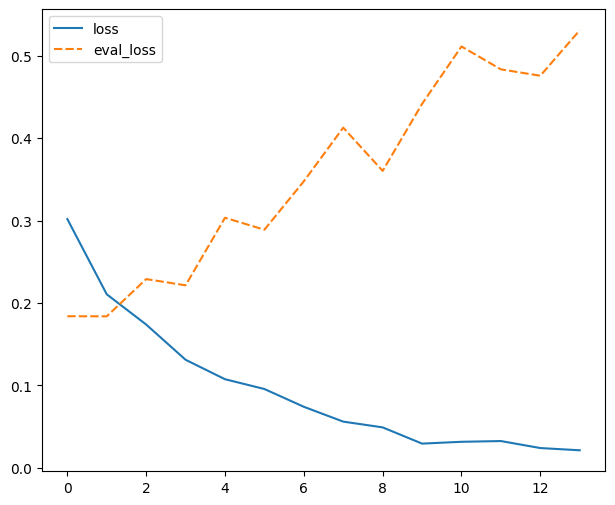

In [14]:
plot_loss_accuracy(mergedDf)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


balanced Accuracy: 0.8503189332408283
accuracy 0.9294465568229827


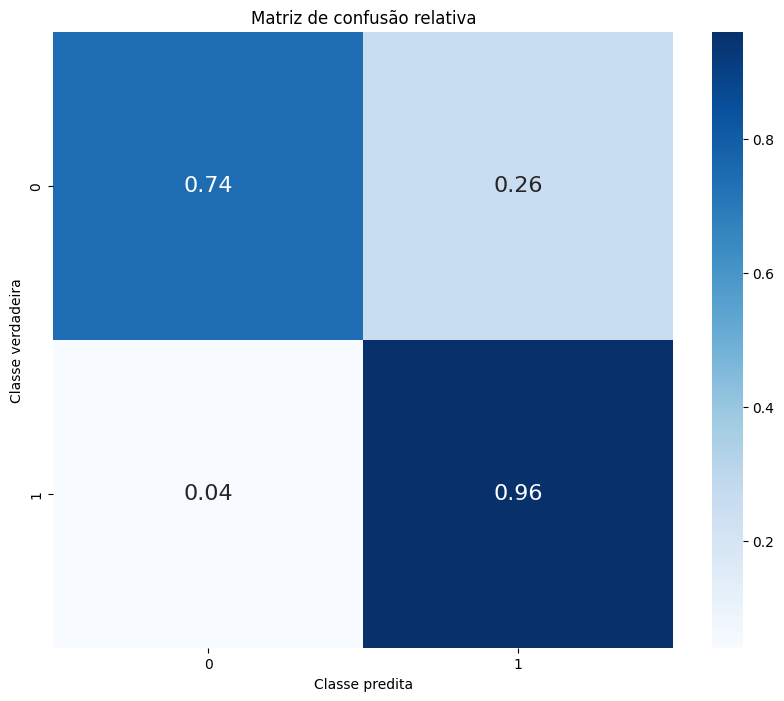

In [24]:
from transformers import pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

predictions = classifier(train_val_set["test"]["Review"], batch_size=16)


plot_confusion_matrix(train_val_set["test"], predictions)

balanced Accuracy: 0.8346604672623537
accuracy 0.9087529570800946


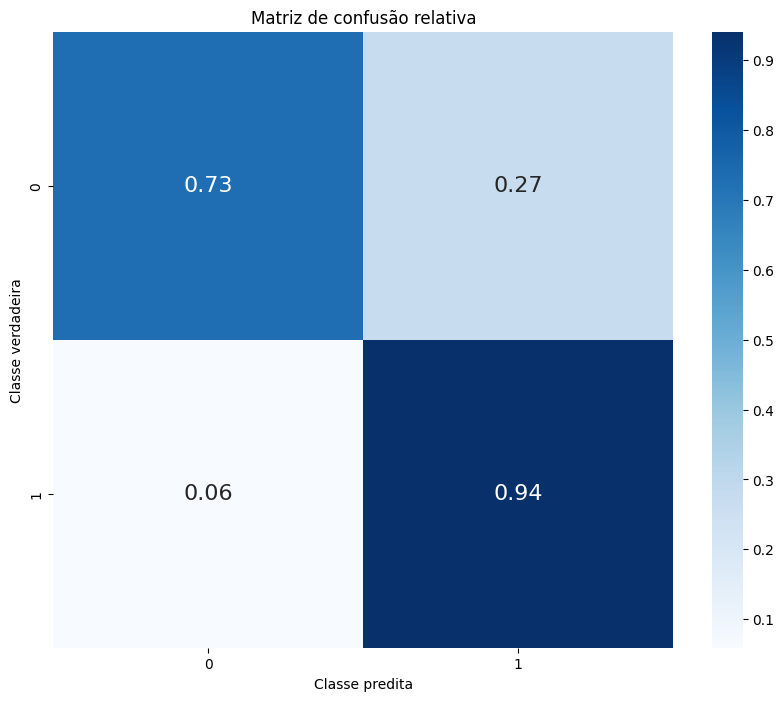

In [25]:
predTest = classifier(test_set["Review"], batch_size=16)
plot_confusion_matrix( test_set, predTest)